<a href="https://colab.research.google.com/github/TacticalNuclearRaccoon/Artificial-Neural-Networks/blob/main/Mobydick_the_whale_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a ResNet binary classifier to detect whale upcalls

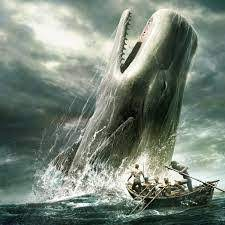

This notebook describes the steps to train a ResNet classifier using data provided by the Meridian project and their Python Library: **Ketos** <br>

The main objective is to obtain a model pre-trained on whales and assess if such model is useful to identify Dolphin audio. <br>

* A GPU type Runtime is recommended for the training. <br> 

Ketos can be installed via pip:

In [1]:
!pip install ketos

     |████████████████████████████████| 181 kB 5.3 MB/s 
     |████████████████████████████████| 209 kB 51.8 MB/s 
  Created wheel for ketos: filename=ketos-2.4.0-py3-none-any.whl size=226286 sha256=437ef636a470ec9cd69e525b03f94683b79230114d16bd4b1c41ab3c9fa91ca6
  Stored in directory: /root/.cache/pip/wheels/a9/74/ec/07b9dbb748e2c8bd8c2e71833a4ff12edd76f4e6b5864fdbcb
  Created wheel for datetime-glob: filename=datetime_glob-1.0.8-py3-none-any.whl size=7980 sha256=168cfd1af63dc6e6383567f2786c6288a8dc83115e489ff0e4ba8e938f7b0c2b
  Stored in directory: /root/.cache/pip/wheels/66/83/5f/fc21bcb17423bdbb629b5faea89d6307d6fc4b7f4976ded714
  Created wheel for lexery: filename=lexery-1.1.1-py3-none-any.whl size=4892 sha256=37ecd6c793743a316a4d9e1cd56ca94fad3d3c2390bc304178a11ec87b13df51
  Stored in directory: /root/.cache/pip/wheels/38/69/66/3916e07b71430a7628b43521720bc4a9d1a8d34f81843533f7
  Created wheel for version-parser: filename=version_parser-1.0.1-py3-none-any.whl size=4863 sha256=e34

##Importing Libraries

In [2]:
import pandas as pd
from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.audio.spectrogram import MagSpectrogram
from ketos.data_handling.parsing import load_audio_representation

from ketos.neural_networks.resnet import ResNetInterface
from google.colab import files

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Identifying GPU device and listing:


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#getting the data
!wget https://gitlab.meridian.cs.dal.ca/public_projects/ketos_tutorials/-/raw/master/tutorials/create_database/database_creation_tutorial.zip

--2021-11-25 09:19:33--  https://gitlab.meridian.cs.dal.ca/public_projects/ketos_tutorials/-/raw/master/tutorials/create_database/database_creation_tutorial.zip
Resolving gitlab.meridian.cs.dal.ca (gitlab.meridian.cs.dal.ca)... 206.12.88.81
Connecting to gitlab.meridian.cs.dal.ca (gitlab.meridian.cs.dal.ca)|206.12.88.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169628696 (162M) [application/zip]
Saving to: ‘database_creation_tutorial.zip’

database_creation_t 100%[===================>] 161.77M  44.8MB/s    in 4.0s    

2021-11-25 09:19:39 (40.6 MB/s) - ‘database_creation_tutorial.zip’ saved [169628696/169628696]



In [4]:
!unzip -q database_creation_tutorial.zip

The spec file contained here is not the good one (missing the "duration" attribute: only 7 attributes instead of 8 ). Therefore I'll replace it with the correct one that I made ;) 

In [19]:
!cat spec_config.json

{
    "spectrogram": {
	"rate": "1000 Hz", 
        "window": "0.256 s",
        "step": "0.032 s",
        "freq_min": "0 Hz",
        "freq_max": "500 Hz",
        "window_func": "hamming",
        "type": "MagSpectrogram"
    }
}



In [ ]:
good_spec=files.upload()

In [ ]:
!cat spec_config2.json

In [6]:
#Loading annotations
annot_train = pd.read_csv("annotations_train.csv")
annot_test = pd.read_csv("annotations_test.csv")

In [7]:
#checking if annotations are confom to ketos standard
sl.is_standardized(annot_train) #f*ck it it is not the ketos format T_T

 Your table is not in the Ketos format.

            It should have two levels of indices: filename and annot_id.
            It should also contain at least the 'label' column.
            If your annotations have time information, these should appear in the 'start' and 'end' columns

            extra columns are allowed.

            Here is a minimum example:

                                 label
            filename  annot_id                    
            file1.wav 0          2
                      1          1
                      2          2
            file2.wav 0          2
                      1          2
                      2          1


            And here is a table with time information and a few extra columns ('min_freq', 'max_freq' and 'file_time_stamp')

                                 start   end  label  min_freq  max_freq  file_time_stamp
            filename  annot_id                    
            file1.wav 0           7.0   8.1      2    180.6     2

False

In [8]:
#standardizing the annotations
map_to_ketos_annot_std ={'sound_file': 'filename'} 
std_annot_train = sl.standardize(table=annot_train, signal_labels=["upcall"], mapper=map_to_ketos_annot_std, trim_table=True)
std_annot_test = sl.standardize(table=annot_test, signal_labels=["upcall"], mapper=map_to_ketos_annot_std, trim_table=True)

In [9]:
sl.is_standardized(std_annot_train) #now it is ketos format!

True

In [10]:
#creating segments of uniform lenght
positives_train = sl.select(annotations=std_annot_train, length=3.0)
positives_test = sl.select(annotations=std_annot_test, length=3.0, step=0.0, center=False)

**data augmentation:**

In [11]:
#adding overlaps & frameshifts
positives_train = sl.select(annotations=std_annot_train, length=3.0, step=0.5, min_overlap=0.5, center=False)

In [12]:
#adding background from negative files (not useful when there is already background noise)
file_durations_train = sl.file_duration_table('data/train')
file_durations_test = sl.file_duration_table('data/test') 

In [13]:
#generating the negatives
negatives_train=sl.create_rndm_backgr_selections(annotations=std_annot_train, files=file_durations_train, length=3.0, num=len(positives_train), trim_table=True)
negatives_train

start         end  label
filename                      sel_id                               
NOPP6_EST_20090328_000000.wav 0        41.619078   44.619078      0
                              1        44.722179   47.722179      0
                              2        44.836232   47.836232      0
                              3        65.699086   68.699086      0
                              4        78.649139   81.649139      0
...                                          ...         ...    ...
NOPP6_EST_20090329_031500.wav 30      837.981858  840.981858      0
                              31      844.220272  847.220272      0
                              32      863.158764  866.158764      0
                              33      879.408035  882.408035      0
                              34      879.503803  882.503803      0

[2778 rows x 3 columns]

In [14]:
negatives_test=sl.create_rndm_backgr_selections(annotations=std_annot_train, files=file_durations_test, length=3.0, num=len(positives_test), trim_table=True)
negatives_test

start         end  label
filename                      sel_id                               
NOPP6_EST_20090329_084500.wav 0        79.080859   82.080859      0
                              1       194.200688  197.200688      0
                              2       197.613408  200.613408      0
                              3       252.888952  255.888952      0
                              4       324.618766  327.618766      0
...                                          ...         ...    ...
NOPP6_EST_20090329_130000.wav 25      799.360671  802.360671      0
                              26      809.093182  812.093182      0
                              27      842.802305  845.802305      0
                              28      868.186376  871.186376      0
                              29      886.930020  889.930020      0

[500 rows x 3 columns]

In [15]:
selections_train = positives_train.append(negatives_train, sort=False)
selections_test = positives_test.append(negatives_test, sort=False)

In [26]:
#choosing spectrogram settings
spec_cfg = load_audio_representation('spec_config2.json', name="spectrogram")

In [27]:
spec_cfg

{'duration': 3.0,
 'freq_max': 500,
 'freq_min': 0,
 'rate': 1000,
 'step': 0.032,
 'type': 'MagSpectrogram',
 'window': 0.256,
 'window_func': 'hamming'}

to try: different types of spectrograms (other than Mag) can be tested...

In [28]:
#creating database
dbi.create_database(output_file='database.h5', data_dir='data/train',
                               dataset_name='train',selections=selections_train,
                               audio_repres=spec_cfg)

100%|██████████| 5556/5556 [01:11<00:00, 78.13it/s]

5556 items saved to database.h5


In [29]:
dbi.create_database(output_file='database.h5', data_dir='data/test',
                               dataset_name='test',selections=selections_test,
                               audio_repres=spec_cfg)

100%|██████████| 1000/1000 [00:12<00:00, 78.01it/s]

1000 items saved to database.h5


In [30]:
db = dbi.open_file("database.h5", 'r')

In [31]:
db

File(filename=database.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/test (Group) ''
/test/data (Table(1000,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(94, 129), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (5,)
/train (Group) ''
/train/data (Table(5556,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(94, 129), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (5,)

In [32]:
db.close()

Stragely enough, the only way to avoid a NodeError further down is to close this database and reopen it O_o

In [33]:
import numpy as np
np.random.seed(1000)

import tensorflow as tf
tf.random.set_seed(2000)

import ketos.data_handling.database_interface as dbi
from ketos.neural_networks.resnet import ResNetInterface
from ketos.data_handling.data_feeding import BatchGenerator

In [34]:
db = dbi.open_file("database.h5", 'r')

In [35]:
#I don't have enough data to split into 3 batches: train, val & test. Therefore I'll be testing on val_data.
#This is also intentional to trigger my colleague Benoit >_<
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/test/data")

In [36]:
# Below is an example of a simple data transformation function
# (However, in this tutorial we will use the ResNetInterface.transform_batch function provided by Ketos)
def transform_batch(X, Y):
  x = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
  y = tf.one_hot(Y['label'], depth=2, axis=1).numpy()
  return x, y
train_generator = BatchGenerator(batch_size=128, data_table=train_data, 
                                  output_transform_func=ResNetInterface.transform_batch,
                                  shuffle=True, refresh_on_epoch_end=True)

In [37]:
val_generator = BatchGenerator(batch_size=128, data_table=val_data,
                                 output_transform_func=ResNetInterface.transform_batch,
                                 shuffle=True, refresh_on_epoch_end=False)

In [38]:
#retrieveing the packaged model
narw = files.upload()

Saving narw.kt to narw.kt


In [39]:
recipe_file = files.upload()

Saving recipe.json to recipe.json


In [40]:
import ketos.neural_networks.dev_utils.detection as det
from ketos.audio.spectrogram import MagSpectrogram
from ketos.audio.audio_loader import AudioFrameLoader
from ketos.neural_networks.resnet import ResNetInterface

In [41]:
resnet = ResNetInterface.build_from_recipe_file("recipe.json")

In [42]:
resnet.train_generator = train_generator
resnet.val_generator = val_generator

In [43]:
resnet.checkpoint_dir = "checkpoints"

In [45]:
resnet.train_loop(n_epochs=30, verbose=True, log_csv=True, csv_name='log.csv')

#train_loop(n_epochs, verbose=True, validate=True, log_tensorboard=False, tensorboard_metrics_name='tensorboard_metrics', log_csv=False, csv_name='log.csv', checkpoint_freq=5, early_stopping=False)


Epoch: 1 
train_loss: 0.09483323246240616
train_CategoricalAccuracy: 0.952 train_Precision: 0.968 train_Recall: 0.935 
val_loss: 0.44631704688072205
val_CategoricalAccuracy: 0.555 val_Precision: 0.951 val_Recall: 0.116 


Epoch: 2 
train_loss: 0.07572465389966965
train_CategoricalAccuracy: 0.965 train_Precision: 0.974 train_Recall: 0.956 
val_loss: 0.31321021914482117
val_CategoricalAccuracy: 0.778 val_Precision: 0.899 val_Recall: 0.626 


Epoch: 3 
train_loss: 0.05262605473399162
train_CategoricalAccuracy: 0.979 train_Precision: 0.982 train_Recall: 0.974 
val_loss: 0.3740425109863281
val_CategoricalAccuracy: 0.679 val_Precision: 0.909 val_Recall: 0.398 


Epoch: 4 
train_loss: 0.04490292817354202
train_CategoricalAccuracy: 0.981 train_Precision: 0.984 train_Recall: 0.979 
val_loss: 0.26266220211982727
val_CategoricalAccuracy: 0.765 val_Precision: 0.903 val_Recall: 0.594 


Epoch: 5 
train_loss: 0.03833281993865967
train_CategoricalAccuracy: 0.985 train_Precision: 0.987 train_Recall: 

KeyboardInterrupt: ignored

In [46]:
db.close()

In [47]:
#saving the model
#Ketos uses a .kt format where they compress the weights and the json recipe altogether
resnet.save_model('Mobydick1.kt',audio_repr_file='spec_config2.json')